# NPs as starting points to clinical trials from the patent perspective 

In [1]:
import pandas as pd
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Disable warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", category=FutureWarning)

# Load patent dataset from SureChEMBL

In [3]:
# Load data (takes a while)
patent_df = pd.read_parquet("../../data/np_scored_surechembl_dump.pq")
patent_df.head(2)

,SureChEMBL_ID,SMILES,InChIKey,PATENT_ID,PUBLICATION_DATE,Field,inchikey_main,np_score,year
index,,,,,,,,,
0,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,None,2004,None,FAKRSMQSSFJEIM,0.112746,2004
1,SCHEMBL9,O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...,OYFJQPXVCSSHAI-QFPUQLAESA-N,None,2004,None,OYFJQPXVCSSHAI,-0.131772,2004


In [4]:
f"Number of unique SMILES: {len(patent_df['SMILES'].unique())}",
f"Number of patents: {len(patent_df['PATENT_ID'].unique())}"

'Number of patents: 230651'

# NP classification

In [5]:
np_class_list = []

for score in tqdm(patent_df["np_score"]):
    if score > 0.6:
        np_class_list.append("np")
    elif score < 0:
        np_class_list.append("synthetics")
    else:
        np_class_list.append("hybrid")

patent_df["np_class"] = np_class_list

# Generate yearly counts

In [6]:
year_data = []

for year in tqdm(patent_df["year"].unique()):
    tmp = patent_df[patent_df["year"] == year]
    counter = tmp["np_class"].value_counts().to_dict()
    counter = {k: int(v) for k, v in counter.items()}
    if year == "2004":
        year = " Until 2014"
    counter["year"] = year
    year_data.append(counter)

In [7]:
year_df = pd.DataFrame(year_data)
year_df

,synthetics,hybrid,np,year
0,9910998,1979897,1063211,Until 2014
1,632125,92300,58433,2015
2,660878,97931,56411,2016
3,858064,167592,105048,2017
4,536673,91385,49067,2018
5,627799,109023,62455,2019
6,800749,131242,68001,2020
7,825739,137294,72046,2021
8,447113,76199,35280,2022


In [8]:
hybrid_percentage = []
np_percentage = []
synthetics_percentage = []

for row in year_df.values:
    (synthetic_count, hybrid_count, np_count, year) = row
    val = synthetic_count + hybrid_count + np_count
    hybrid_percentage.append((hybrid_count / val) * 100)
    np_percentage.append((np_count / val) * 100)
    synthetics_percentage.append((synthetic_count / val) * 100)

year_df["hybrid_percentage"] = hybrid_percentage
year_df["np_percentage"] = np_percentage
year_df["synthetics_percentage"] = synthetics_percentage

# Overview of the annual distribution

In [9]:
import string

sns.set_style("whitegrid")

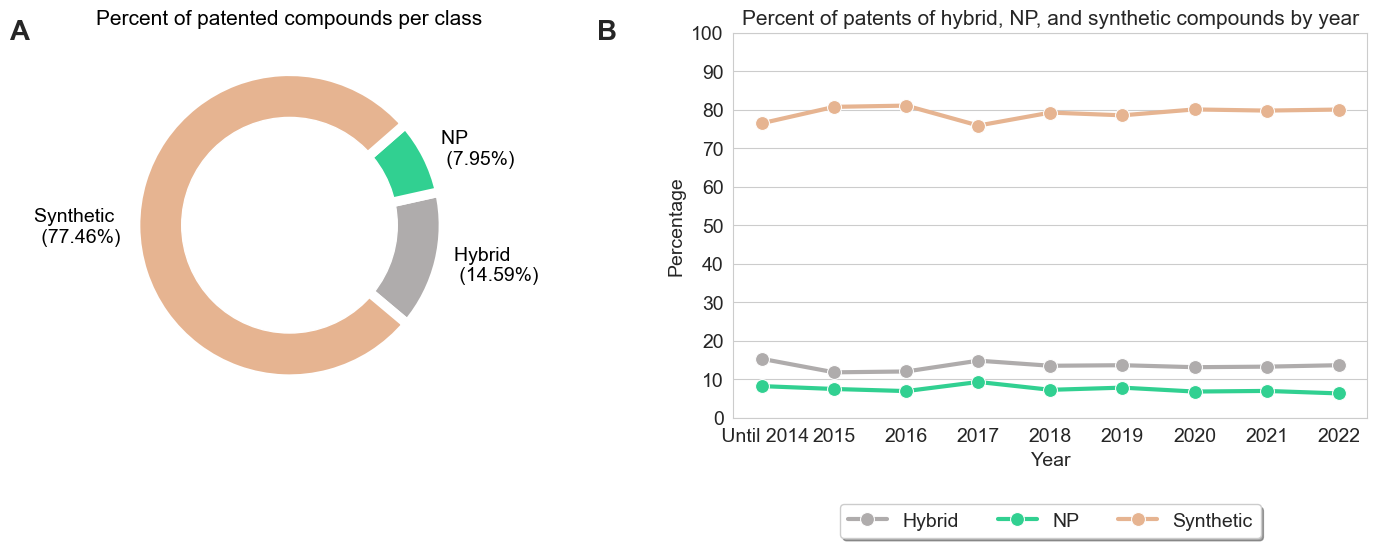

In [10]:
# 2 subplots
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
my_circle = plt.Circle((0, 0), 0.7, color="white")

data = [14.59, 7.95, 77.46]  # Percentages

# Give color names
plt.pie(
    data,
    labels=["Hybrid \n (14.59%)", "NP \n (7.95%)", "Synthetic \n (77.46%)"],
    colors=["#afacac", "#31d091", "#e6b491"],
    wedgeprops={"linewidth": 7, "edgecolor": "white"},
    startangle=-40,
    # autopct="%1.1f%%",
    # pctdistance=0.85,
    textprops={"fontsize": 14, "color": "black"},
)

p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Percent of patented compounds per class", fontsize=15, color="black")
plt.text(
    -0.2,
    1,
    string.ascii_uppercase[0],
    size=20,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.subplot(1, 2, 2)
ax = sns.lineplot(
    data=year_df,
    x="year",
    y="hybrid_percentage",
    label="Hybrid",
    color="#afacac",
    marker="o",
    linewidth=3,
    markersize=10,
)
ax.grid(axis="x")

sns.lineplot(
    data=year_df,
    x="year",
    y="np_percentage",
    label="NP",
    color="#31d091",
    ax=ax,
    marker="o",
    linewidth=3,
    markersize=10,
)
sns.lineplot(
    data=year_df,
    x="year",
    y="synthetics_percentage",
    label="Synthetic",
    color="#e6b491",
    ax=ax,
    marker="o",
    linewidth=3,
    markersize=10,
)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, ticks=range(0, 101, 10))
plt.ylim(top=100)

plt.title(
    "Percent of patents of hybrid, NP, and synthetic compounds by year", fontsize=15
)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    shadow=True,
    ncol=3,
    fontsize=14,
)

plt.text(
    -0.2,
    1,
    string.ascii_uppercase[1],
    size=20,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)


plt.savefig("../../data/output/plots/figure_3.png", dpi=600, bbox_inches="tight")
plt.show()